In [1]:
import argparse
import os
import imageio
import shutil

import gymnasium as gym
import torch
from tqdm import tqdm

import config
from utils import preprocess
from dqn import DQN, ReplayMemory, optimize
import matplotlib.pyplot as plt
from IPython.core.display import Image as img
from PIL import Image

In [2]:
def reset_image_folder():
  if os.path.exists('images'): shutil.rmtree('images')
  os.mkdir('images')

def show_animation():
  i = 0
  fnames = []
  while os.path.exists(f'images/{i}.png'):
    fnames.append(f'images/{i}.png')
    i+=1
  imageio.mimsave('images/anim.gif', [imageio.imread(fname) for fname in fnames])
  return img(filename='images/anim.gif')

In [3]:
def evaluate_policy(dqn, env, n_episodes, render=False, verbose=False):
    """Runs {n_episodes} episodes to evaluate current policy."""
    total_return = 0
    for i in range(n_episodes):
        obs, info = env.reset()
        obs = preprocess(obs, env='CartPole-v1').unsqueeze(0)

        terminated = False
        episode_return = 0
        steps = 0

        while not terminated:
            if render:
                rep = env.render()
                # save the rep as an image
                im = Image.fromarray(rep).convert('RGB')
                im.save(f'images/{steps}.png')

            action = dqn.act(obs, exploit=True).item()
            steps += 1
            obs, reward, terminated, truncated, info = env.step(action)
            obs = preprocess(obs, env='CartPole-v1').unsqueeze(0)

            episode_return += reward
        
        total_return += episode_return
        
        if verbose:
            print(f'Finished episode {i+1} with a total return of {episode_return}')

    
    return total_return / n_episodes

In [4]:
# env config
env_config = {
    'memory_size': 50000,
    'n_episodes': 1,
    'batch_size': 32,
    'target_update_frequency': 10,
    'train_frequency': 1,
    'gamma': 0.95,
    'lr': 1e-4,
    'eps_start': 1.0,
    'eps_end': 0.05,
    'anneal_length': 10**4,
    'n_actions': 2,
}

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# env
env = gym.make('CartPole-v1', render_mode='rgb_array')

# model
dqn = torch.load('models/CartPole-v1_best.pt').to(device)
dqn.eval()

# evaluate
total_return = evaluate_policy(dqn, env, env_config['n_episodes'], render=True, verbose=True)

print(f'Average return over {env_config["n_episodes"]} episodes: {total_return}')

env.close()

Finished episode 1 with a total return of 694.0
Average return over 1 episodes: 694.0


C:\Users\melvi\AppData\Local\Temp\ipykernel_20644\431434986.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave('images/anim.gif', [imageio.imread(fname) for fname in fnames])


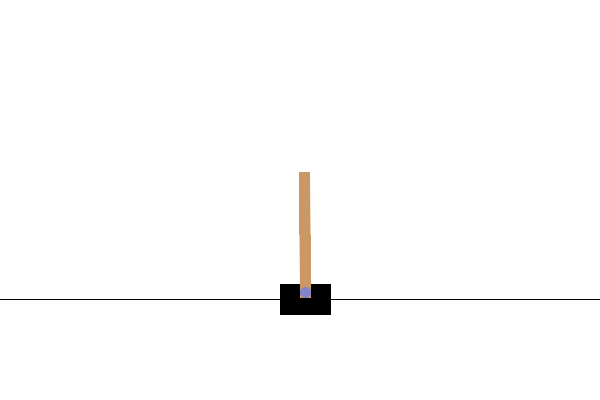

In [9]:
# show animation
show_animation()